# [Kaggle competition: Cassava Leaf Disease Classification](https://www.kaggle.com/c/cassava-leaf-disease-classification/)
#### *Identifing the type of disease present on a Cassava Leaf image*

In this competition, we explore a dataset consisting of 21,367 labeled photographs of Cassava leaves collected during a regular survey in Uganda. Images were crowdsourced from farmers and annotated by experts at the National Crops Resources Research Institute (NaCRRI) in collaboration with the AI lab at Makerere University, Kampala.

Our task is to classify each image into one of 5 categories: one indicating a **healthy** leaf, and the remaining four categories indicating different diseases. These are **Cassava Bacteria Blight** (CBB), **Cassava Brown Streak Disease** (CBSD), **Cassava Green Mottle** (CGM), and **Cassava Mosaic Disease** (CMD). 

This Notebook contains:

1. Exploratory Data Analysis (EDA) of the Cassava leaf image dataset, and demonstration of image augmentation techniques using the Albumentations library.

2. Training and finetuning a ResNet-152 model from torchvision (PyTorch) with GPU P100 accelerator. 

3. Ensembling out-of-fold (OOF) predictions with test time augmentations (TTA). 

4. Preparing our final submission for this competition.

## Import libraries:

First we will import all necessary libraries and set CUDA as our device (since we will be training our model with GPU).

In [10]:
import torch
import torch.nn as nn
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from torchinfo import summary

from torchvision.models import resnet152, ResNet152_Weights

import albumentations 
from albumentations.pytorch.transforms import ToTensorV2

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split, StratifiedKFold

import os
import copy
import glob
import json
import random
import pathlib
from PIL import Image
import pickle 

In [12]:
BASE_PATH = '..\\Cassava-Leaf\\'
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
# print(f'Device: {DEVICE}')

# 1. Exploratory Data Analysis (EDA) and Image Augmentations

First, let's read our training data (consisting of image ids and their corresponding label) into a pandas dataframe, and display the first 10 entries:

In [13]:
df = pd.read_csv(BASE_PATH + 'train.csv')
df.head(10)

image_id  label
0  1000015157.jpg      0
1  1000201771.jpg      3
2   100042118.jpg      1
3  1000723321.jpg      1
4  1000812911.jpg      3
5  1000837476.jpg      3
6  1000910826.jpg      2
7  1001320321.jpg      0
8  1001723730.jpg      4
9  1001742395.jpg      3

The label numbers here correspond to disease status, with the mapping contained in a JSON file:

In [14]:
labels = json.load(open(BASE_PATH + "label_num_to_disease_map.json"))
labels = {int(key):value for key, value in labels.items()}
labels

{0: 'Cassava Bacterial Blight (CBB)',
 1: 'Cassava Brown Streak Disease (CBSD)',
 2: 'Cassava Green Mottle (CGM)',
 3: 'Cassava Mosaic Disease (CMD)',
 4: 'Healthy'}

The integer labels $0$, $1$, $2$, and $3$ correspond to four distinct diseases of the Cassava leaf, while the label $4$ indicates a healthy leaf. We can also check for any null entries and confirm the number of training samples:

In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21397 entries, 0 to 21396
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   image_id  21397 non-null  object
 1   label     21397 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 334.5+ KB


We can also check the frequency of each disease category. We see that we have imbalanced data with class $3$ (Cassava Mosaic Disease) heavily respresented: over 60\% of training samples belong to this class. Therefore, it is advisable to use stratified K-fold cross-validation to ensure the class distribution in each fold of the training dataset matches the class distribution of the full training dataset, as we will show in the next section.

In [16]:
df['label'].value_counts()

3    13158
4     2577
2     2386
1     2189
0     1087
Name: label, dtype: int64

Each **image_id** is the filename of a JPEG image contained in the **train_images** directory. Let's create a function to display some randomly chosen sample images from each disease category.

In [44]:
def display_images(label, rows, cols):
    
    number = rows * cols
    
    new_df = df[df['label'] == label]
    
    img_list = random.sample(new_df['image_id'].tolist(), number)
    
    plt.figure(figsize=(7, 7))
    for index, img_id in enumerate(img_list):
        plt.subplot(rows, cols, index+1)
        image = Image.open(BASE_PATH + "/train_images/" + img_id)
        plt.imshow(image, aspect='auto')
        plt.axis('off')
        
    plt.suptitle(f'\n\n Class {label}: ' + labels[label], fontsize=20)
    plt.tight_layout()

In [49]:
%%javascript
IPython.OutputArea.auto_scroll_threshold = 9999

<IPython.core.display.Javascript object>

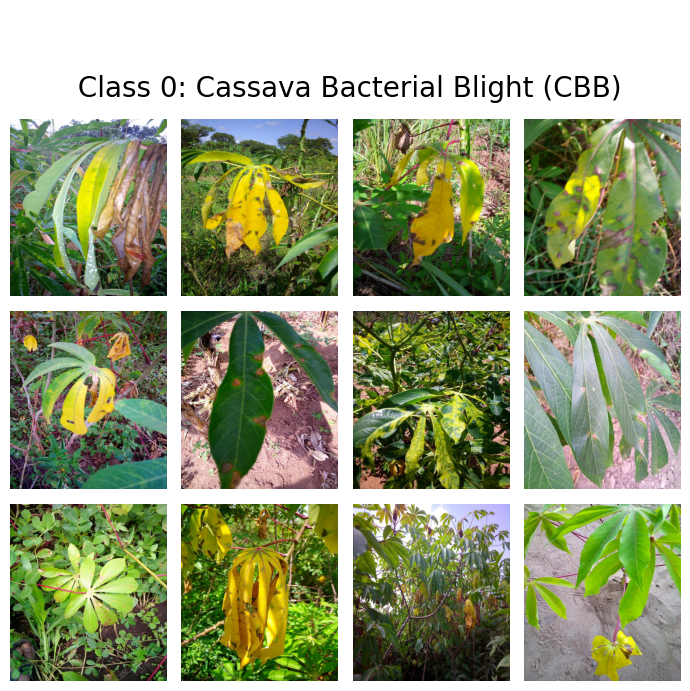

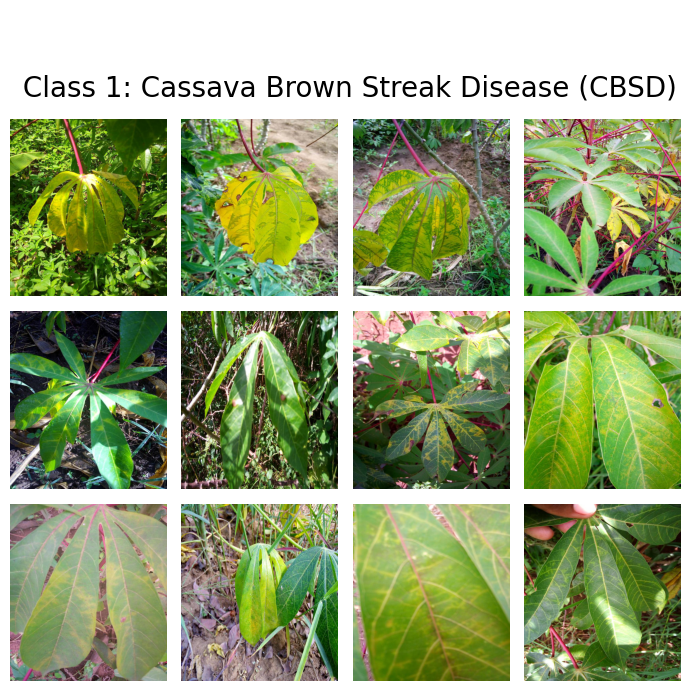

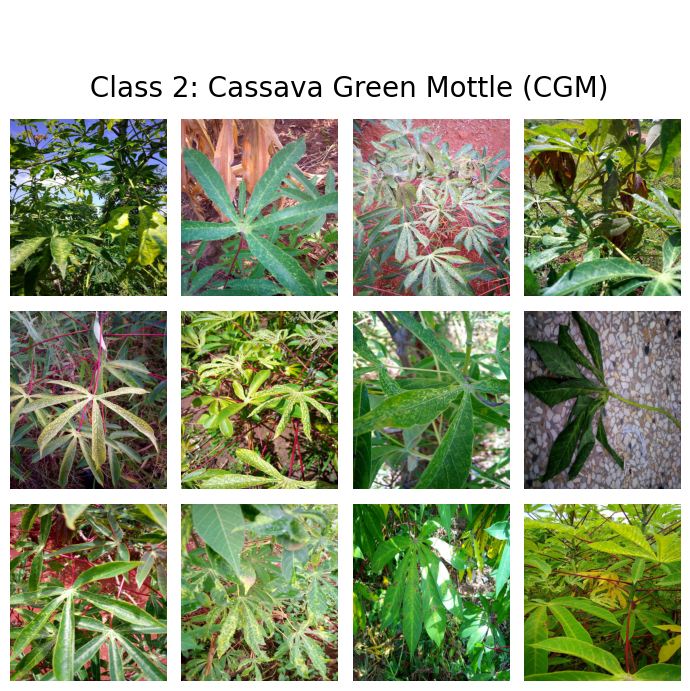

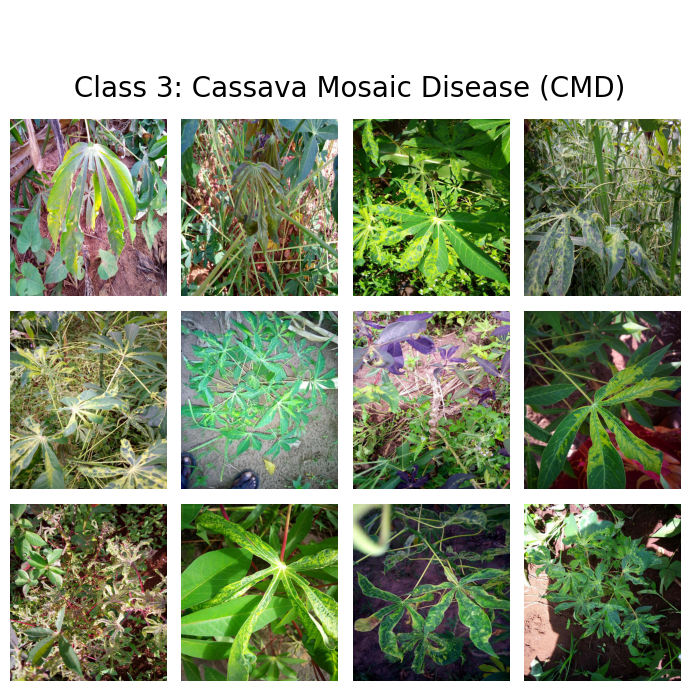

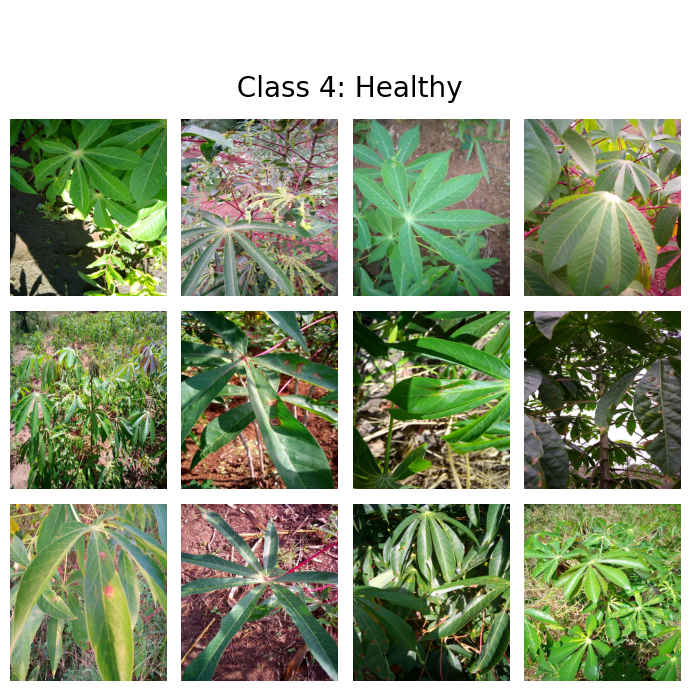

In [59]:
random.seed(70)
for i in range(5):
    display_images(label=i, rows=3, cols=4)

Each image has dimensions of $800 \times 600$ pixels, with leaves generally present in the center of the frame. We can also see that images are taken in a range of lighting conditions. Compared to healthy leaves, some visual features of diseased leaves are immediately apparent:

Class $0$, Cassava Bacterial Blight (CBB): wilting, brown lesions and/or holes present 

Class $1$, Cassava Brown Streak Disease (CBSD): yellow/light brown patches on leaf and within veins

Class $2$, Cassava Green Mottle (CGM): yellow or green spots, distorted leaf edges

Class $3$, Cassava Mosaic Disease (CMD): moasaic patterning/yellowing

In addition to basic augmentations such as center cropping and performing vertical/horizontal flips of an image, it may therefore be beneficial to introduce augmentations which shift the brightness, hue, color saturation, and contrast of the image, which may make these visual symptoms more readily distinguishable. 

We'll use the Albumentations library to generate modified versions of our training samples. By increasing the quantity and diversity of our training data, our deep learning model should generalize better to unseen test samples (avoiding overfitting), and prediction accuracy should improve.

Below we illustrate some individual transformations on a single example image. In practice, we will compose several of these transformations together in an augmentation pipeline during the training phase (some occuring with probability $p$, which we set to $1$ here for illustration purposes). 

## Image Augmentations using Albumentations

## Original Image:

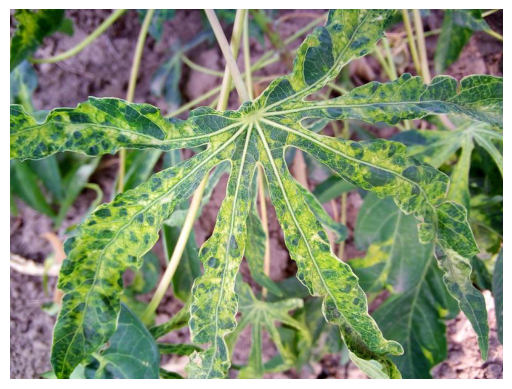

In [60]:
example_id = df['image_id'][19]
example_image = Image.open(BASE_PATH + "/train_images/" + example_id)
plt.figure()
plt.imshow(example_image)
plt.axis('off')
plt.show()

## Vertical Flip:

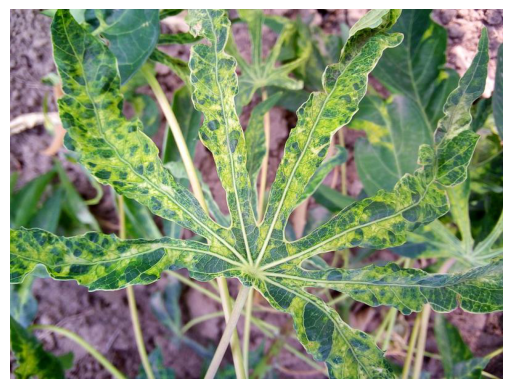

In [61]:
vertical_transform = albumentations.VerticalFlip(p=1)
augmented_image = vertical_transform(image=np.array(example_image))['image']
plt.figure()
plt.imshow(augmented_image)
plt.axis('off')
plt.show()

## Horizontal Flip:

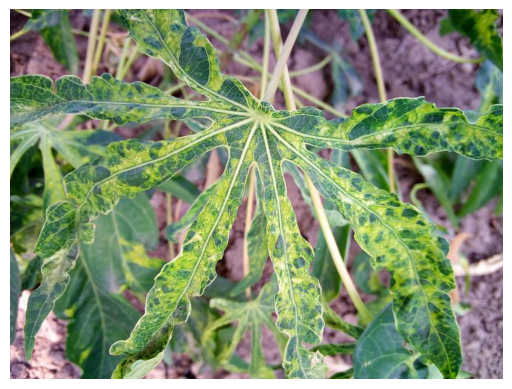

In [62]:
horizontal_transform = albumentations.HorizontalFlip(p=1)
augmented_image = horizontal_transform(image=np.array(example_image))['image']
plt.figure()
plt.imshow(augmented_image)
plt.axis('off')
plt.show()

## Random Resized Crop:

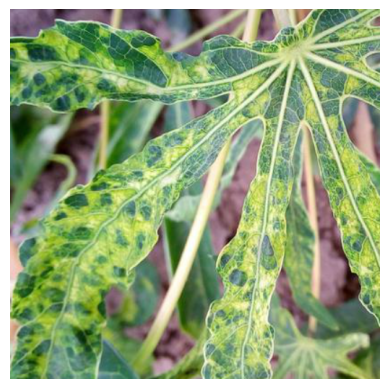

In [63]:
random_crop_transform = albumentations.RandomResizedCrop(width=512, height=512)
augmented_image = random_crop_transform(image=np.array(example_image))['image']
plt.figure()
plt.imshow(augmented_image)
plt.axis('off')
plt.show()

## Transpose:

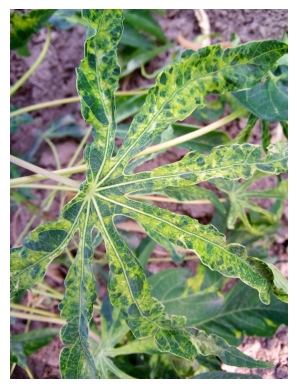

In [64]:
transpose_transform = albumentations.Transpose(p=1)
augmented_image = transpose_transform(image=np.array(example_image))['image']
plt.figure()
plt.imshow(augmented_image)
plt.axis('off')
plt.show()

## Shift Scale Rotate:

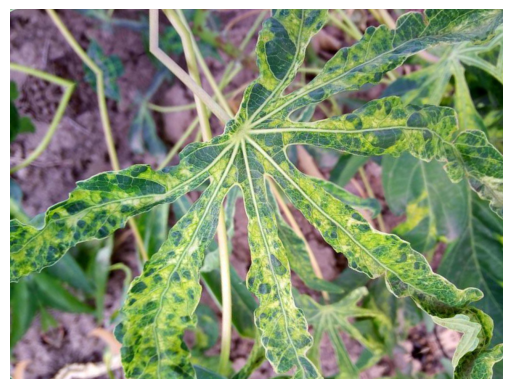

In [65]:
shift_scale_rotate_transform = albumentations.ShiftScaleRotate(p=1)
augmented_image = shift_scale_rotate_transform(image=np.array(example_image))['image']
plt.figure()
plt.imshow(augmented_image)
plt.axis('off')
plt.show()

## Hue Saturation Value transform:

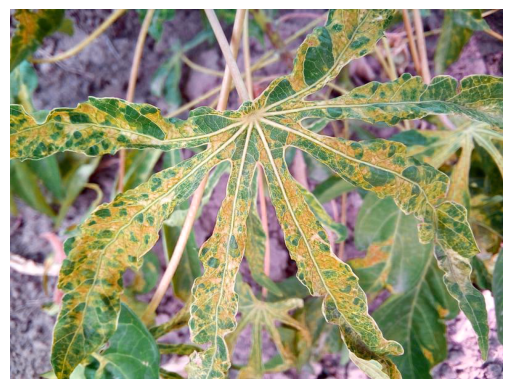

In [66]:
hue_saturation_value_transform = albumentations.HueSaturationValue(
    hue_shift_limit=20,
    sat_shift_limit=50,
    val_shift_limit=20,
    p=1)
augmented_image = hue_saturation_value_transform(image=np.array(example_image))['image']
plt.figure()
plt.imshow(augmented_image)
plt.axis('off')
plt.show()

## Random Brightness Contrast transform:

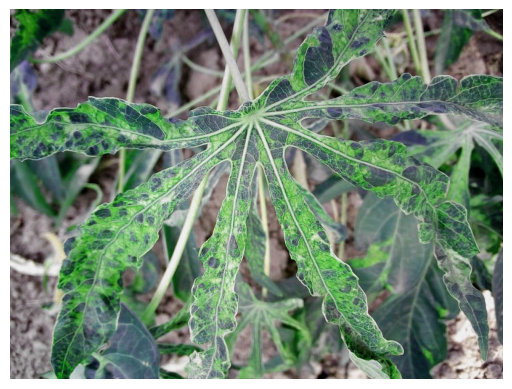

In [67]:
random_brightness_contrast_transform = albumentations.RandomBrightnessContrast(
    brightness_limit=(-0.1, 0.1), 
    contrast_limit=(-0.1, 0.1), 
    p=1)
augmented_image = hue_saturation_value_transform(image=np.array(example_image))['image']
plt.figure()
plt.imshow(augmented_image)
plt.axis('off')
plt.show()